In [1]:
from typing import Callable, List, Tuple
import collections
from PIL import Image
import os
import torch

from torch import optim
from torch import nn


import solaris as sol
import segmentation_models_pytorch as smp

from pathlib import Path
from models.unets import unet_resnet
from dataflow.dataloaders import get_train_val_loaders
from dataflow.visualisations import tensor_to_rgb
from dataflow.transforms import get_train_augmentation, get_validation_augmentation, prepare_batch_fp32, get_preprocessing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import catalyst
from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl import SupervisedRunner
from catalyst.data import Augmentor
from catalyst.dl import utils
from catalyst.data.reader import ImageReader, ScalarReader, ReaderCompose, LambdaReader
from catalyst.contrib.nn import RAdam, Lookahead
from catalyst.dl.callbacks import DiceCallback, EarlyStoppingCallback, InferCallback, CheckpointCallback

from datetime import datetime

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wwymak/anaconda3/envs/solaris/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wwymak/anaconda3/envs/solaris/lib/pyt

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


In [3]:
data_dir = Path('/media/wwymak/Storage/spacenet')
summary_data = data_dir / 'summary_ids.csv'
summary_data_df = pd.read_csv(summary_data)


In [6]:
debug=False
batch_size = 4
val_batch_size = batch_size * 2
num_workers = 12
val_interval = 3
accumulation_steps = 4


model, preprocessing_fn = unet_resnet("efficientnet-b0")
runner = SupervisedRunner(device="cuda:0", input_key="image", input_target_key="mask", model=model)

train_loader, val_loader, test_loader = get_train_val_loaders(
    summary_data_filepath=summary_data,
    train_transforms= get_train_augmentation(is_display=False, image_size=512, normalisation_fn=None),
    val_transforms= get_validation_augmentation(is_display=False, image_size=512, normalisation_fn=None),
    batch_size=batch_size,
    num_workers = num_workers
)

loaders = collections.OrderedDict()
loaders["train"] = train_loader
loaders["valid"] = val_loader

(4999, 9)
(4249, 9)


In [8]:
logdir = data_dir /"experiment_tracking"/"unets"/ '2020-08-02-19_512_512_inputs'
predictions = np.vstack(list(map(
    lambda x: x["logits"].cpu().numpy(), 
    runner.predict_loader(loader=test_loader, resume=f"{logdir}/checkpoints/best.pth")
)))

In [9]:
predictions.shape, predictions.max(), predictions.min()

((405, 1, 512, 512), 1.0, 1.7107513e-10)

In [10]:
mask_image = np.array(Image.fromarray(predictions[0].squeeze() * 255).convert('L'))

In [11]:
image_id = Path(test_loader.dataset.image_filepath_list[0]).stem.replace('RGB-PanSharpen_', '')
image_info = summary_data_df[summary_data_df.image_id==image_id]

In [21]:
from post_processing.georeferencing import georeference_image
import tempfile
import skimage
import rasterio
import geopandas as gpd

In [18]:
mask_image.shape

(512, 512)

In [47]:
with tempfile.TemporaryDirectory() as temp_dir:
    temp_dir = Path(temp_dir)
    skimage.io.imsave(temp_dir/'temp.tif',mask_image, plugin='tifffile')
    output_filepath  = temp_dir/'temp_out.tif'
    georeference_image(temp_dir/'temp.tif', output_filepath, 650, 650, image_info.bottom.values[0], image_info.top.values[0], image_info.left.values[0], image_info.right.values[0])
    
    with rasterio.open(str(output_filepath)) as ref:
        transform = ref.transform
        crs = ref.crs
        tile_bounds = ref.bounds
        ref.close()
        
        print(tile_bounds)
    arr2 = skimage.io.imread(output_filepath, plugin='tifffile' )
    geoms = sol.vector.mask.mask_to_poly_geojson(arr2, bg_threshold=0.5)
    print(geoms) 
    print(arr2.max())
    mask = mask_image > 125
    shapes = rasterio.features.shapes(arr2, mask=mask, transform=transform)
    
#     print(gpd.GeoDataFrame(list(shapes)))
    from shapely.geometry import shape
    geom = [shape(i[0]) for i in list(shapes)]
    v2 = gpd.GeoDataFrame({'geometry':geom})
#     v2 = sol.vector.mask.mask_to_poly_geojson(arr2, reference_im=str(output_filepath), do_transform=True,  bg_threshold=0.9)
    print(v2)

BoundingBox(left=-115.1653626, bottom=36.13218029970001, right=-115.1639802, top=36.1335626997)
                                            geometry  value
0  POLYGON ((444.000 22.000, 444.000 23.000, 445....  255.0
1  POLYGON ((139.000 115.000, 139.000 117.000, 13...  255.0
2  POLYGON ((109.000 147.000, 109.000 148.000, 10...  255.0
3  POLYGON ((316.000 234.000, 316.000 235.000, 31...  255.0
4  POLYGON ((511.000 21.000, 511.000 23.000, 510....  255.0
5  POLYGON ((329.000 425.000, 329.000 426.000, 32...  255.0
6  POLYGON ((243.000 372.000, 243.000 373.000, 24...  255.0
7  POLYGON ((464.000 405.000, 464.000 406.000, 46...  255.0
255
                                               geometry
0     POLYGON ((-115.16398 36.13350, -115.16398 36.1...
1     POLYGON ((-115.16401 36.13350, -115.16401 36.1...
2     POLYGON ((-115.16401 36.13350, -115.16401 36.1...
3     POLYGON ((-115.16401 36.13350, -115.16401 36.1...
4     POLYGON ((-115.16400 36.13350, -115.16400 36.1...
...                     

In [55]:
v2.crs = "epsg:4326"
# v2.geometry = v2.geometry.apply(
#             lambda x: x.simplify(tolerance=0.1)
#         )
v2_proj = v2.to_crs(epsg="8379")
v2_proj[v2_proj.area > 40]

,geometry
133,"POLYGON ((82235.772 187082.783, 82235.771 1870..."
300,"POLYGON ((82226.502 187066.322, 82226.502 1870..."
785,"POLYGON ((82234.569 187089.078, 82234.568 1870..."
1485,"POLYGON ((82173.828 186981.036, 82173.827 1869..."
1499,"POLYGON ((82172.377 186984.634, 82172.376 1869..."
1591,"POLYGON ((82229.950 186968.936, 82229.947 1869..."
1770,"POLYGON ((82226.316 186974.637, 82226.315 1869..."


In [56]:
from shapely.geometry import Polygon
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

v2_proj.geometry = v2_proj.geometry.apply(lambda p: close_holes(p))

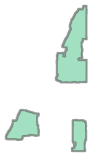

In [57]:
from shapely.ops import cascaded_union
cascaded_union(v2_proj[v2_proj.area > 40]['geometry'])

In [46]:
geoms

,geometry,value
0,"POLYGON ((444.000 22.000, 444.000 23.000, 445....",255.0
1,"POLYGON ((139.000 115.000, 139.000 117.000, 13...",255.0
2,"POLYGON ((109.000 147.000, 109.000 148.000, 10...",255.0
3,"POLYGON ((316.000 234.000, 316.000 235.000, 31...",255.0
4,"POLYGON ((511.000 21.000, 511.000 23.000, 510....",255.0
5,"POLYGON ((329.000 425.000, 329.000 426.000, 32...",255.0
6,"POLYGON ((243.000 372.000, 243.000 373.000, 24...",255.0
7,"POLYGON ((464.000 405.000, 464.000 406.000, 46...",255.0


In [49]:
sol.vector.mask.mask_to_poly_geojson(arr2, reference_im= bg_threshold=0.5)

array([[ 4,  0,  0, ...,  0,  0,  4],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [10,  1,  0, ...,  3,  3, 10]], dtype=uint8)